# Train Eval Baseline for CelebA Dataset
---

## Import Libraries

In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from disenn.datasets.celeba_dataset import CelebA

from disenn.models.conceptizers import VaeConceptizer
from disenn.models.parameterizers import ConvParameterizer
from disenn.models.aggregators import SumAggregator
from disenn.models.disenn import DiSENN

from disenn.models.losses import celeba_robustness_loss
from disenn.models.losses import BVAE_loss

## Seed

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Sample dataset for baseline

In [4]:
SAMPLE_SIZE = 100

In [5]:
celeba_dataset = CelebA(split='train', data_path='data/celeba')

In [6]:
sample_idxs = np.random.permutation(len(celeba_dataset))[:SAMPLE_SIZE]
sample_celeba_dataset = [celeba_dataset[idx] for idx in sample_idxs]
sample_images = [x for x,_ in sample_celeba_dataset]
sample_labels = [y for _,y in sample_celeba_dataset]

In [14]:
plt.plot.bar(sample_labels)

[0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

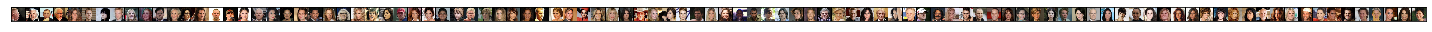

In [7]:
sample_images_grid = make_grid(sample_images,nrow=SAMPLE_SIZE)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(sample_images_grid.numpy().transpose(1,2,0))
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [8]:
sample_dl = DataLoader(sample_celeba_dataset, batch_size=10, shuffle=True)

In [9]:
x,y = next(iter(sample_dl))

# $\beta$-VAE Conceptizer

## Forward Pass

In [10]:
conceptizer = VaeConceptizer(num_concepts=10)

In [11]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)

In [12]:
x.shape

torch.Size([10, 3, 64, 64])

In [13]:
concept_mean.shape, concept_logvar.shape

(torch.Size([10, 10]), torch.Size([10, 10]))

In [14]:
x_reconstruct.shape

torch.Size([10, 3, 64, 64])

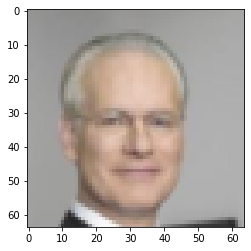

In [15]:
plt.imshow(x[0].numpy().transpose(1,2,0))

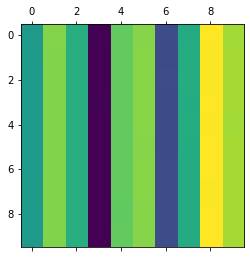

In [16]:
plt.matshow(concept_mean.detach().numpy())

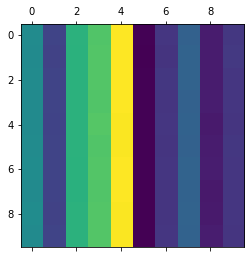

In [17]:
plt.matshow(concept_logvar.detach().numpy())

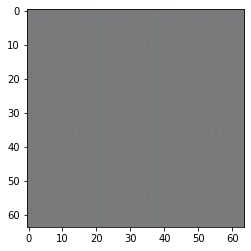

In [18]:
plt.imshow(x_reconstruct[0].detach().numpy().transpose(1,2,0))

## Backward Gradients

In [19]:
conceptizer = VaeConceptizer(num_concepts=10)

In [20]:
# concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
# recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
# loss = recon_loss + kl_div
# loss.backward()

In [21]:
_, _, x_reconstruct = conceptizer(x)
loss = F.binary_cross_entropy(x_reconstruct, x, reduction="mean")
loss.backward()
loss

tensor(0.6953, grad_fn=<BinaryCrossEntropyBackward>)

In [22]:
print(conceptizer.decoder.tconv_block[-1].weight.grad.mean())
print(conceptizer.decoder.tconv_block[-1].weight.grad.std())

tensor(6.8655e-05)
tensor(0.0001)


In [23]:
print(conceptizer.decoder.tconv_block[-3].weight.grad.mean())
print(conceptizer.decoder.tconv_block[-3].weight.grad.std())

tensor(-1.0300e-06)
tensor(1.1198e-05)


In [24]:
print(conceptizer.encoder.logvar_layer.weight.grad.mean())
print(conceptizer.encoder.mu_layer.weight.grad.std())

tensor(5.9506e-11)
tensor(2.5406e-09)


## Training

In [41]:
conceptizer = VaeConceptizer(num_concepts=10)

In [42]:
optimizer = optim.Adam(conceptizer.parameters())
conceptizer.train();
recorder = []

In [43]:
EPOCHS = 100
BETA = 1
PRINT_FREQ = 10

In [ ]:
for epoch in range(EPOCHS):
    for i, (x, _) in enumerate(sample_dl):
        optimizer.zero_grad()
        concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        loss = recon_loss + BETA * kl_div
        loss.backward()
        optimizer.step()
        recorder.append([loss, recon_loss, 0.0])

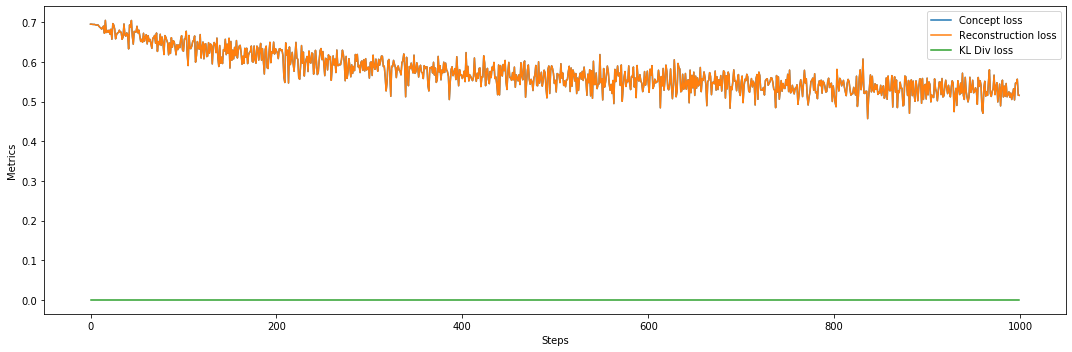

In [29]:
steps = list(range(len(recorder)))
recorder = np.array(recorder)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(steps, recorder[:,0], label="Concept loss")
ax.plot(steps, recorder[:,1], label="Reconstruction loss")
ax.plot(steps, recorder[:,2], label="KL Div loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Metrics")
ax.legend()
fig.tight_layout()

In [30]:
conceptizer.eval();

In [31]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
# x_reconstruct, _, _ = conceptizer(x)

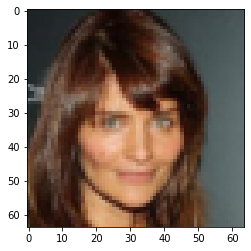

In [40]:
plt.imshow(x[0].numpy().transpose(1,2,0))

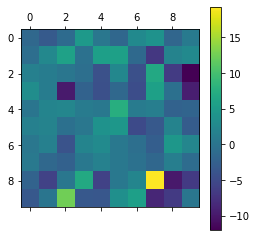

In [33]:
plt.matshow(concept_mean.detach().numpy())
plt.colorbar()

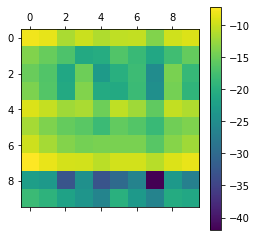

In [34]:
plt.matshow(concept_logvar.detach().numpy())
plt.colorbar()

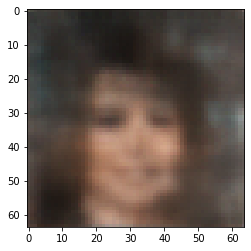

In [39]:
plt.imshow(x_reconstruct[0].detach().numpy().transpose(1,2,0))

**Observations**:  
* KL Divergence affects the reconstruction loss such that all images tend to look similar
* Reducing beta to 0 drastically improves reconstruction loss
* Does it hold when we have reasonable data?

# DiSENN

## Forward Pass

In [24]:
NUM_CONCEPTS = 10
NUM_CLASS = 2

In [25]:
conceptizer = VaeConceptizer(NUM_CONCEPTS)

In [26]:
parameterizer = ConvParameterizer(NUM_CONCEPTS, NUM_CLASS)

In [27]:
aggregator = SumAggregator(NUM_CLASS)

In [28]:
disenn = DiSENN(conceptizer, parameterizer, aggregator)

In [29]:
y_pred, explanation, x_construct = disenn(x)

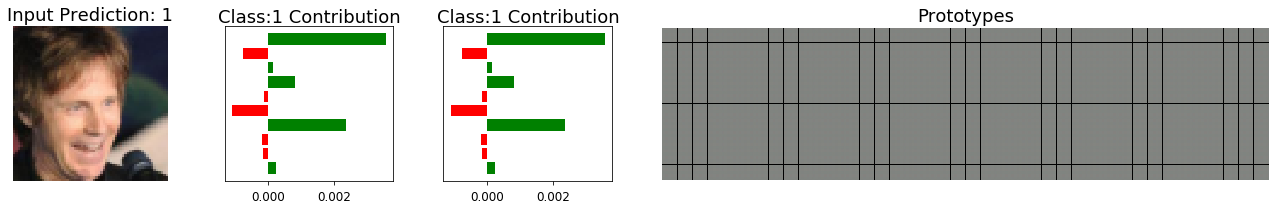

In [30]:
disenn.explain(x[0], 1, show=True, num_prototypes=40)

## Training

In [31]:
EPOCHS = 1
BETA = 1
ROBUST_REG = 1e-4
PRINT_FREQ = 5

In [32]:
opt = optim.Adam(disenn.parameters())
disenn.train();

In [33]:
for epoch in range(EPOCHS):
    for i, (x, labels) in enumerate(train_dl):
        x = x.float()
        labels = labels.long()
        opt.zero_grad()

        # track all operations on x for jacobian calculation
        x.requires_grad_(True)
        y_pred, (concepts_dist, relevances), x_reconstruct = disenn(x)

        concept_mean, concept_logvar = concepts_dist
        concepts = concept_mean

        pred_loss = F.nll_loss(y_pred.squeeze(-1), labels)
        robustness_loss = celeba_robustness_loss(x, y_pred, concepts, relevances)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        concept_loss = recon_loss + BETA * kl_div

        total_loss = pred_loss + concept_loss + (ROBUST_REG * robustness_loss) 
        total_loss.backward()
        opt.step()

        if i % PRINT_FREQ == 0:
            print(f"EPOCH:{epoch} STEP:{i} \t"
                  f"Loss: {total_loss:.3f} "
                  f"Pred Loss: {pred_loss:.3f} "
                  f"Robust Loss: {robustness_loss:.3f} "
                  f"Concept Loss: {concept_loss:.3f} "
                  f"Recon Loss: {recon_loss:.3f} "
                  f"KL Div: {kl_div:.5f}")

EPOCH:0 STEP:0 	Loss: 0.843 Pred Loss: 0.694 Robust Loss: 0.001 Concept Loss: 0.149 Recon Loss: 0.085 KL Div: 0.06467
EPOCH:0 STEP:5 	Loss: 0.799 Pred Loss: 0.693 Robust Loss: 0.001 Concept Loss: 0.106 Recon Loss: 0.104 KL Div: 0.00137
EPOCH:0 STEP:10 	Loss: 0.796 Pred Loss: 0.693 Robust Loss: 0.000 Concept Loss: 0.102 Recon Loss: 0.101 KL Div: 0.00147


KeyboardInterrupt: 

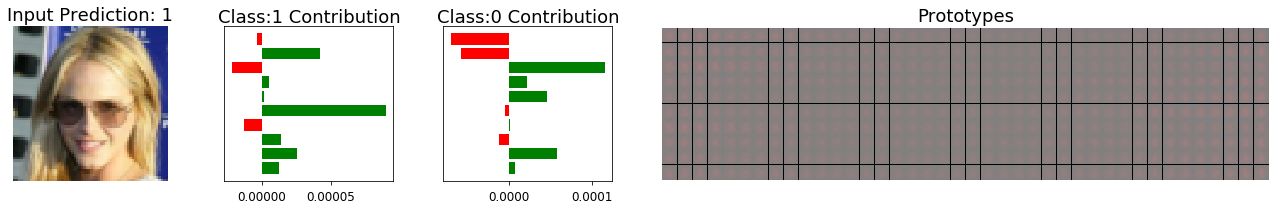

In [34]:
disenn.explain(x[5].detach(), 0, show=True, num_prototypes=40)